In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

In [4]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage(deep=True).sum() / (1024 ** 2) 
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage(deep=True).sum() / (1024 ** 2)
    print(f"start_mem Memory usage of df_train: {start_mem:.2f} MB")
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [5]:
df_train_trans = pd.read_csv('../input/train_transaction.csv')
df_train_identity = pd.read_csv('../input/train_identity.csv')

df_train = df_train_trans.merge(df_train_identity, how='left', on='TransactionID')

print(df_train.shape)
del df_train_trans, df_train_identity


(590540, 434)


In [191]:
df_train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [6]:
df_train = reduce_mem_usage(df_train)       

start_mem Memory usage of df_train: 2567.09 MB
Mem. usage decreased to 1257.69 Mb (51.0% reduction)


In [7]:
# Label encoding for categorical features
for col in df_train.select_dtypes(include='object').columns:
    lbl = LabelEncoder()
        
    encoded_values = lbl.fit_transform(df_train[col]) 
        
    #Replace the NaN (which becomes -1 after LabelEncoding) with -999
    encoded_values[df_train[col].isnull()] = -999
        
    # Step 5: Assign the encoded values back to the column
    df_train[col] = encoded_values
df_train.fillna(-999, inplace=True)
percent_missing = (df_train == -999).mean() * 100

# Identify columns where more than 50% of the values are missing
cols_to_drop = percent_missing[percent_missing > 50].index

# Drop these columns
df_train_cleaned = df_train.drop(columns=cols_to_drop)

# Display the cleaned dataframe
print(f"Columns removed: {cols_to_drop}")
print(f"Shape of the cleaned dataframe: {df_train_cleaned.shape}")

Columns removed: Index(['dist1', 'dist2', 'R_emaildomain', 'D5', 'D6', 'D7', 'D8', 'D9', 'D12',
       'D13',
       ...
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo'],
      dtype='object', length=214)
Shape of the cleaned dataframe: (590540, 220)


In [8]:
df_train_cleaned = df_train_cleaned.drop('TransactionID', axis=1)
df_train_cleaned.shape

(590540, 219)

In [9]:
X_train = df_train_cleaned.select_dtypes(include=['number']).drop(columns=['isFraud'])
y_train = df_train_cleaned['isFraud']  # This is the target variable

In [10]:
majority_class_indices = np.where(y_train == 0)[0]
minority_class_indices = np.where(y_train == 1)[0] 

oversampled_minority_class_indices = np.random.choice(minority_class_indices, len(majority_class_indices), replace=True)
balanced_indices = np.concatenate([majority_class_indices, oversampled_minority_class_indices])

np.random.shuffle(balanced_indices)
X_train_resampled = X_train.iloc[balanced_indices]
y_train_resampled = y_train.iloc[balanced_indices]

In [11]:
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_val_scaled = scaler.transform(X_val)

In [227]:
df_train["isFraud"].value_counts()

isFraud
0    569877
1     20663
Name: count, dtype: int64

In [33]:
count_minus_999 = (df_train_cleaned == -999).sum()

# Sort the result in descending order
count_minus_999_sorted_desc = count_minus_999.sort_values(ascending=False)

# Display the sorted result
print(count_minus_999_sorted_desc)

M4                281444
D2                280797
V10               279287
V5                279287
V4                279287
                   ...  
C10                    0
C11                    0
TransactionDT          0
TransactionAmt         0
isFraud                0
Length: 219, dtype: int64


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [ ]:
import tensorflow as tf

# Build a Neural Network Model
model = Sequential()

# Input Layer
model.add(Input(shape=(X_train_scaled.shape[1],)))

# Hidden Layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.F1Score(threshold=0.5)]
)


Epoch 1/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 34s 3ms/step - f1_score: 0.7570 - loss: 0.4966 - val_f1_score: 0.7543 - val_loss: 0.4602
Epoch 2/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - f1_score: 0.7972 - loss: 0.4243 - val_f1_score: 0.7831 - val_loss: 0.4118
Epoch 3/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 33s 3ms/step - f1_score: 0.8161 - loss: 0.3900 - val_f1_score: 0.8311 - val_loss: 0.3639
Epoch 4/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - f1_score: 0.8278 - loss: 0.3668 - val_f1_score: 0.8314 - val_loss: 0.3601
Epoch 5/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - f1_score: 0.8370 - loss: 0.3494 - val_f1_score: 0.8420 - val_loss: 0.3433
Epoch 6/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - f1_score: 0.8440 - loss: 0.3347 - val_f1_score: 0.8541 - val_loss: 0.3273
Epoch 7/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - f1_score: 0.8511 - loss: 0.3221 - val_f1_score: 0.8521 - val_loss: 0.3186
Epoch 8/100
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - f1

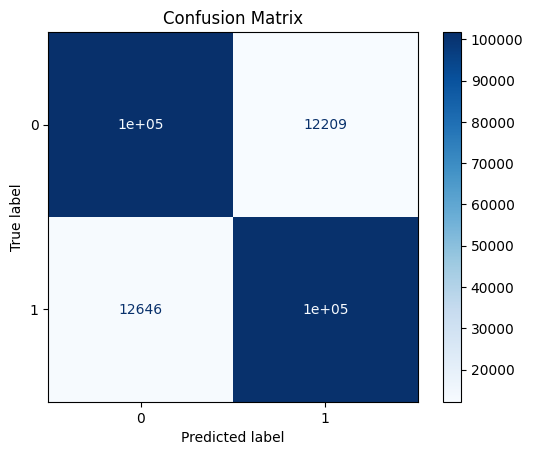

In [153]:
history = model.fit(X_train_scaled, y_train_final, 
                    epochs=100,                   # Allow for many, early stopping will cut it short
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # <- This is what enables early stopping
                    verbose=1
                    )

# Evaluate the model on the test set
y_pred_proba = model.predict(X_val_scaled)  # Predict probabilities

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [259]:
def f1_metric(y_true, y_pred):
    y_pred = tf.round(y_pred)  # Round predictions to 0 or 1 for binary classification
    precision = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    recall = tf.reduce_sum(y_true * y_pred) / (tf.reduce_sum(y_true) + tf.keras.backend.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())
    return f1

In [245]:
y_train_final.shape

(911803,)

In [246]:
X_train_scaled.shape

(911803, 218)

In [13]:
import keras_tuner as kt

def model_builder(hp):
  model = tf.keras.Sequential()
  model.add(Input(shape=(X_train_scaled.shape[1],)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units1 = hp.Int('units1', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units1, activation='relu'))

  hp_units2 = hp.Int('units2', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units2, activation='relu'))

  hp_units3 = hp.Int('units3', min_value=16, max_value=64, step=8)
  model.add(tf.keras.layers.Dense(units=hp_units3, activation='relu'))

  # Output layer for binary classification
  model.add(Dense(1, activation='sigmoid')) 
  
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

  f1 = tf.metrics.F1Score(threshold=0.5)
  f1.__name__ = "f1_score"  # <-- manually give it a name!
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='binary_crossentropy',
                metrics=[f1]
                )

  return model


In [2]:
X_train_scaled.shape

NameError: name 'X_train_scaled' is not defined

In [16]:
import os
os.makedirs(r'C:\kmy_dir', exist_ok=True)

tuner = kt.Hyperband(
    model_builder,
    objective=kt.Objective("val_f1_score", direction="max"), 
    max_epochs=25,
    factor=3,
    directory=r'C:\kmy_dir',
    project_name='intro_to_kt'
)


tuner.search(
    X_train_scaled,  
    y_train_final,   
    epochs=100,
    validation_split=0.2, 
    callbacks=[early_stopping],  # Apply early stopping during the search
    verbose=1
)

Trial 25 Complete [00h 21m 05s]
val_f1_score: 0.7222630977630615

Best val_f1_score So Far: 0.9520834684371948
Total elapsed time: 07h 31m 27s


In [17]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

In [20]:
print("Best hyperparameters:")
for hp_name in best_hps.values.keys():
    print(f"{hp_name}: {best_hps.get(hp_name)}")

Best hyperparameters:
units: 512
learning_rate: 0.0001
units1: 256
units2: 416
units3: 480
tuner/epochs: 25
tuner/initial_epoch: 9
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0018


Epoch 1/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 66s 6ms/step - f1_score: 0.7794 - loss: 0.4593 - val_f1_score: 0.8089 - val_loss: 0.4165
Epoch 2/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - f1_score: 0.8090 - loss: 0.4054 - val_f1_score: 0.8195 - val_loss: 0.3837
Epoch 3/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 62s 5ms/step - f1_score: 0.8283 - loss: 0.3686 - val_f1_score: 0.8460 - val_loss: 0.3454
Epoch 4/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - f1_score: 0.8441 - loss: 0.3391 - val_f1_score: 0.8528 - val_loss: 0.3327
Epoch 5/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - f1_score: 0.8582 - loss: 0.3116 - val_f1_score: 0.8675 - val_loss: 0.3037
Epoch 6/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - f1_score: 0.8694 - loss: 0.2886 - val_f1_score: 0.8524 - val_loss: 0.3005
Epoch 7/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 60s 5ms/step - f1_score: 0.8795 - loss: 0.2698 - val_f1_score: 0.8804 - val_loss: 0.2616
Epoch 8/25
11398/11398 ━━━━━━━━━━━━━━━━━━━━ 61s 5ms/step - f1_score: 

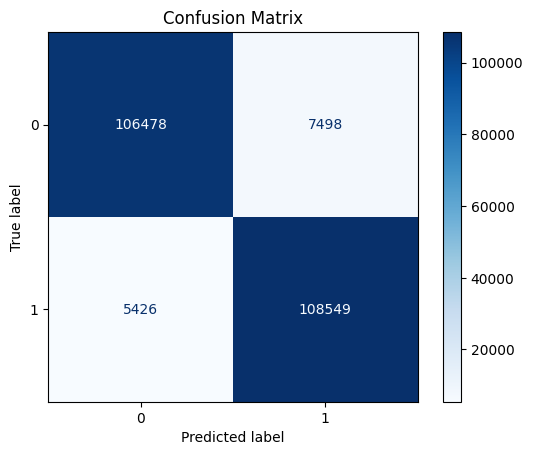

In [22]:
history = model.fit(X_train_scaled, y_train_final, 
                    epochs=25,                   # Allow for many, early stopping will cut it short
                    batch_size=64,
                    validation_split=0.2,
                    callbacks=[early_stopping],  # <- This is what enables early stopping
                    verbose=1
                    )

# Evaluate the model on the test set
y_pred_proba = model.predict(X_val_scaled)  # Predict probabilities

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_val, y_pred))

cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

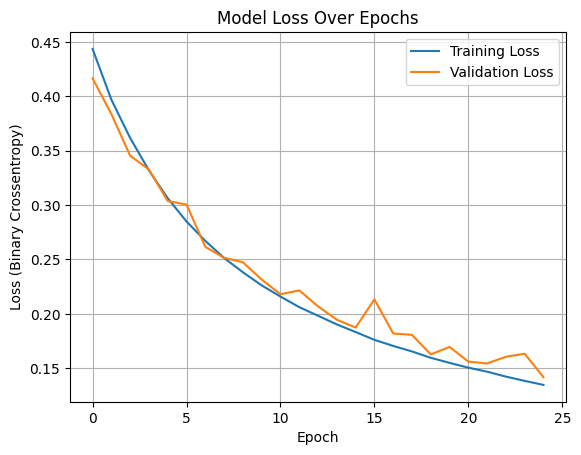

In [23]:
import matplotlib.pyplot as plt

# Plot training & validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Binary Crossentropy)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_train.value_counts()

(590540,)

18455/18455 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.55      0.71    569877
           1       0.07      0.98      0.14     20663

    accuracy                           0.57    590540
   macro avg       0.54      0.77      0.43    590540
weighted avg       0.97      0.57      0.69    590540



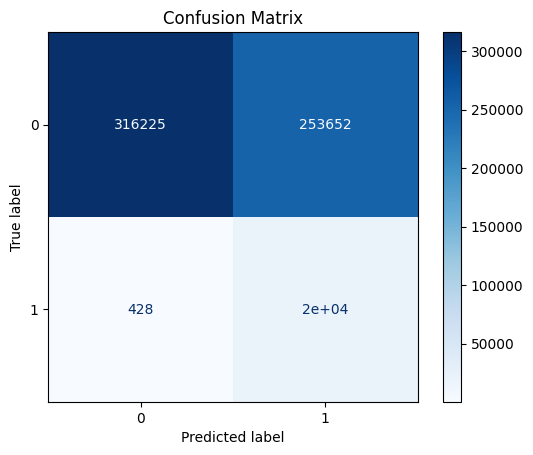

In [27]:

scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train)

# Evaluate the model on the test set
y_pred_proba = model.predict(X_train_scaled1)  # Predict probabilities

# Convert probabilities to class labels (0 or 1)
y_pred = (y_pred_proba > 0.5).astype(int)

print("\nClassification Report:\n", classification_report(y_train, y_pred))

cm = confusion_matrix(y_train, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()